In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_38/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


**Setup**

Si la instalación de lightgbm da error, ejecutar en Anaconda Prompt 

`conda install -c conda-forge xgboost=1.4.0`

`conda install -c conda-forge lightgbm=3.2.1`

---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Prediciendo quiebra de empresas - parte II

Continuando con el ejercicio del Checkpoint, usaremos ahora otros modelos de Boosting:
- LightGBM
- Catboost

Ya hemos visto que XGBoost es una implementación de Gradient Boosting que busca mejorar su performance, y esto lo hace  mediante la aplicación de métodos de regularización para evitar sobreajustes.  

A continuación veremos otros dos implementaciones de Gradient Boosting que también buscan mejorar su performance cada uno con sus propias técnicas, pero principalmente trabajando sobre las técnicas de split.

Cada uno de estos modelos tienen sus pros y cons. En este [link](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc) encontraremos una comparación detallada de cada uno de ellos.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

In [3]:
df = pd.read_csv("../Data/3year.csv")

In [4]:
df.head()

,Unnamed: 0,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [5]:
# eliminamos la primera columna que se trata de un indice.
df = df.drop("Unnamed: 0", axis = 1)

Acá hay una descripción de los atributos

- Attr1: net profit / total assets
- Attr2: total liabilities / total assets
- Attr3: working capital / total assets
- Attr4: current assets / short-term liabilities
- Attr5: [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
- Attr6: retained earnings / total assets
- Attr7: EBIT / total assets
- Attr8: book value of equity / total liabilities
- Attr9: sales / total assets
- Attr10: equity / total assets
- Attr11: (gross profit + extraordinary items + financial expenses) / total assets
- Attr12: gross profit / short-term liabilities
- Attr13: (gross profit + depreciation) / sales
- Attr14: (gross profit + interest) / total assets
- Attr15: (total liabilities * 365) / (gross profit + depreciation)
- Attr16: (gross profit + depreciation) / total liabilities
- Attr17: total assets / total liabilities
- Attr18: gross profit / total assets
- Attr19: gross profit / sales
- Attr20: (inventory * 365) / sales
- Attr21: sales (n) / sales (n-1)
- Attr22: profit on operating activities / total assets
- Attr23: net profit / sales
- Attr24: gross profit (in 3 years) / total assets
- Attr25: (equity - share capital) / total assets
- Attr26: (net profit + depreciation) / total liabilities
- Attr27: profit on operating activities / financial expenses
- Attr28: working capital / fixed assets
- Attr29: logarithm of total assets
- Attr30: (total liabilities - cash) / sales
- Attr31: (gross profit + interest) / sales
- Attr32: (current liabilities * 365) / cost of products sold
- Attr33: operating expenses / short-term liabilities
- Attr34: operating expenses / total liabilities
- Attr35: profit on sales / total assets
- Attr36: total sales / total assets
- Attr37: (current assets - inventories) / long-term liabilities
- Attr38: constant capital / total assets
- Attr39: profit on sales / sales
- Attr40: (current assets - inventory - receivables) / short-term liabilities
- Attr41: total liabilities / ((profit on operating activities + depreciation) * (12/365))
- Attr42: profit on operating activities / sales
- Attr43: rotation receivables + inventory turnover in days
- Attr44: (receivables * 365) / sales
- Attr45: net profit / inventory
- Attr46: (current assets - inventory) / short-term liabilities
- Attr47: (inventory * 365) / cost of products sold
- Attr48: EBITDA (profit on operating activities - depreciation) / total assets
- Attr49: EBITDA (profit on operating activities - depreciation) / sales
- Attr50: current assets / total liabilities
- Attr51: short-term liabilities / total assets
- Attr52: (short-term liabilities * 365) / cost of products sold)
- Attr53: equity / fixed assets
- Attr54: constant capital / fixed assets
- Attr55: working capital
- Attr56: (sales - cost of products sold) / sales
- Attr57: (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
- Attr58: total costs /total sales
- Attr59: long-term liabilities / equity
- Attr60: sales / inventory
- Attr61: sales / receivables
- Attr62: (short-term liabilities *365) / sales
- Attr63: sales / short-term liabilities
- Attr64: sales / fixed assets
- class: toma los valores "b'0'" y "b'1'" indicando si la empresa quebro o no.

### Ejercicio 1
1) Obtener la `matriz de features X` y la `variable target y`  
2) Analizar la forma (shape) del dataset.  
3) Ver los valores que toma la variable target  
4) Aplicar LabelEncoder sobre la variable target.

In [6]:
X = df.drop('class', axis=1)
y = df['class']

In [7]:
df.shape

(10503, 65)

In [8]:
y.value_counts(normalize=True)

b'0'    0.952871
b'1'    0.047129
Name: class, dtype: float64

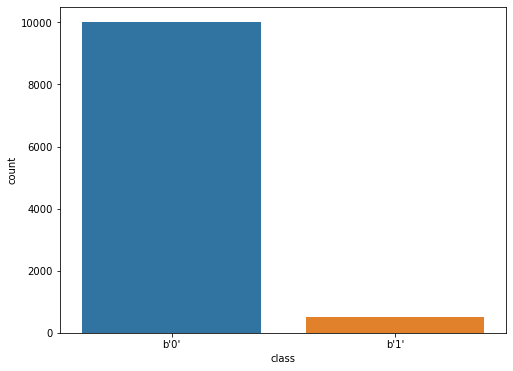

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

plt.figure(figsize=(8,6))

sns.countplot(x=df['class'])
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y = enc.fit_transform(y)

In [11]:
pd.Series(y).value_counts()

0    10008
1      495
dtype: int64

### Ejercicio 2
1) Realizar un split en Train y Test, dejando un 20% para test  
2) crear un generador de CV utilizando: `cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)` para luego pasarselo tanto a `GridSearchCV` como a `cross_val_score`


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test =\
train_test_split(X, y, stratify = y, shuffle =True, random_state = 1203, test_size = .2)


In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV,cross_val_score

In [15]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)

### Ejercicio 3: LightGBM
1) Importar el clasificador `LGBMClassifier()` de la libreria `lightgbm`.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

La lista completa de hiperparámetros se puede consultar [aquí](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)

In [16]:
from lightgbm import LGBMClassifier 

In [30]:
lgbm = LGBMClassifier()

2) Utilizando el siguiente diccionario de parametros, optimizar los hiperparámetros.  
3) Imprimir en pantalla la mejor selección de hiperparámetros

In [31]:
from sklearn.model_selection import GridSearchCV
params = {  
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
    'is_unbalance':[True]              # Target muy desbalanceado
}

In [32]:
gs = GridSearchCV(lgbm, params, n_jobs=-1, cv=kfolds, scoring='f1')

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'is_unbalance': [True], 'learning_rate': [0.01, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 500]},
             scoring='f1')

In [34]:
gs.best_params_

{'is_unbalance': True,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 500}

In [35]:
best_lgbm = gs.best_estimator_

5) Evaluar el rendimiento del estimador optimo, utilizando cross validation.  
(pasarle como argumento cv el generador de CV splits del creado en el punto 3)  
**nota:** ver función evaluar_rendimiento() utilizada en la notebook `2-Boosting_Practica.ipynb`

In [36]:
cv =cross_val_score(best_lgbm, X_train, y_train, scoring='f1', cv = kfolds, n_jobs=-1)
cv

array([0.62068966, 0.65693431, 0.5483871 , 0.60465116, 0.56      ])

In [37]:
# Performance en el set de validacion
cv.mean()

0.5981324442613296

In [39]:
from sklearn.metrics import f1_score

f1_score(y_test, best_lgbm.predict(X_test))

0.6588235294117647

6) utilizando roc_auc_score de la libreria sklearn.metrics, determinar el valor del ROC.

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, best_lgbm.predict(X_test))

0.7790820290820291

7) utilizando plot_roc de la libreria sklearn.metrics, graficamos la curva ROC por clase

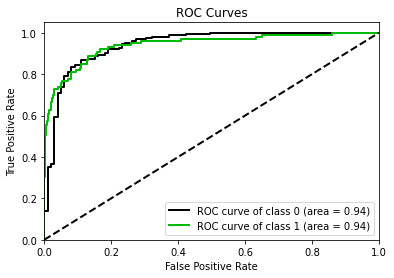

In [41]:
from scikitplot.metrics import plot_roc

plot_roc(y_test, best_lgbm.predict_proba(X_test), plot_micro = False, plot_macro= False);

### BONUS: 
graficar la importancia de los atributos del estimador optimizado.  
**nota:** LightGBM tiene un método propio para graficar`plot_importance` 

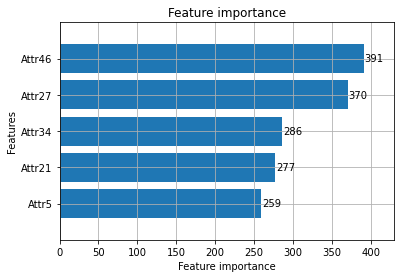

In [50]:
from lightgbm import plot_importance

plot_importance(best_lgbm, height = 0.8,max_num_features=5)
plt.show()

### Ejercicio 4: Catboost
1) Importar el clasificador `CatBoostClassifier()` de la libreria `catboost`.

https://catboost.ai/docs/concepts/about.html

In [52]:
from catboost import CatBoostClassifier



2) Con catboost los resultados sin optimizar hiperparámetros ya son excelentes. Procedemos a entrenar el modelo con los datos de training.

In [54]:
catbclf = CatBoostClassifier().fit(X_train, y_train)

Learning rate set to 0.025565
0:	learn: 0.6560701	total: 74.9ms	remaining: 1m 14s
1:	learn: 0.6223937	total: 80.4ms	remaining: 40.1s
2:	learn: 0.5883591	total: 86ms	remaining: 28.6s
3:	learn: 0.5586125	total: 91.6ms	remaining: 22.8s
4:	learn: 0.5313706	total: 97.6ms	remaining: 19.4s
5:	learn: 0.5055115	total: 103ms	remaining: 17.1s
6:	learn: 0.4789771	total: 109ms	remaining: 15.4s
7:	learn: 0.4508945	total: 115ms	remaining: 14.2s
8:	learn: 0.4306838	total: 120ms	remaining: 13.2s
9:	learn: 0.4121620	total: 126ms	remaining: 12.5s
10:	learn: 0.3954654	total: 132ms	remaining: 11.9s
11:	learn: 0.3795877	total: 138ms	remaining: 11.4s
12:	learn: 0.3653096	total: 144ms	remaining: 10.9s
13:	learn: 0.3518719	total: 150ms	remaining: 10.5s
14:	learn: 0.3370665	total: 157ms	remaining: 10.3s
15:	learn: 0.3257498	total: 163ms	remaining: 10s
16:	learn: 0.3154010	total: 168ms	remaining: 9.73s
17:	learn: 0.3048469	total: 178ms	remaining: 9.73s
18:	learn: 0.2962171	total: 184ms	remaining: 9.52s
19:	learn

3) Una vez entrenado el modelo, realizar las predicciones sobre el dataset de prueba. 

In [55]:
y_pred = catbclf.predict(X_test)

4) utilizando roc_auc_score de la libreria sklearn.metrics, determinar el valor del ROC.

In [56]:
roc_auc_score(y_test, y_pred)

0.7116217116217117

5) utilizando plot_roc de la libreria sklearn.metrics, graficamos la curva ROC por clase

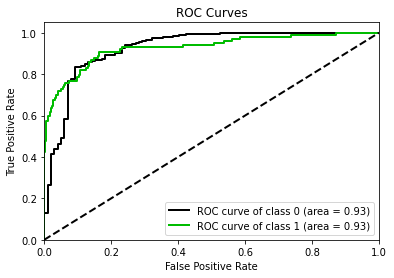

In [57]:
plot_roc(y_test, catbclf.predict_proba(X_test), plot_micro = False, plot_macro= False);